In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [ ]:
%%capture
!pip install transformers

In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
# change the datapath when you run

datapath = '/content/drive/MyDrive/CS546/course-project/SemEval/data/data_en_subtask1/train.csv'
df = pd.read_csv(datapath)
df.head()

,id,text,type,label
0,833042063,Chelsea Handler Admits She’s ‘Very Sexually At...,satire,2
1,832959523,How Theresa May Botched\n\nThose were the time...,satire,2
2,833039623,Robert Mueller III Rests His Case—Dems NEVER W...,satire,2
3,833032367,Robert Mueller Not Recommending Any More Indic...,satire,2
4,814777937,The Far Right Is Trying to Co-opt the Yellow V...,satire,2


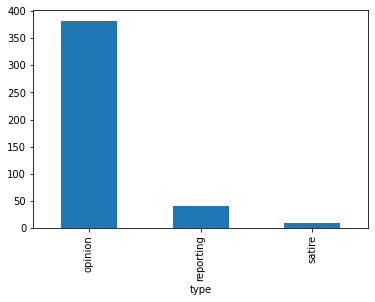

In [ ]:
# visualize the imbalance

df.groupby(['type']).size().plot.bar()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'satire': 2, 'opinion': 0, 'reporting': 1}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [labels[label] for label in df['type']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=3, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=3)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

346 43 44


In [ ]:
EPOCHS = 1
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 116/116 [00:34<00:00,  3.33it/s]


Epochs: 1 | Train Loss:  0.254 | Train Accuracy:  0.812 | Val Loss:  0.198 | Val Accuracy:  0.930


100%|██████████| 116/116 [00:36<00:00,  3.14it/s]


Epochs: 2 | Train Loss:  0.196 | Train Accuracy:  0.870 | Val Loss:  0.156 | Val Accuracy:  0.930


100%|██████████| 116/116 [00:38<00:00,  2.98it/s]


Epochs: 3 | Train Loss:  0.165 | Train Accuracy:  0.876 | Val Loss:  0.131 | Val Accuracy:  0.930


100%|██████████| 116/116 [00:37<00:00,  3.07it/s]


Epochs: 4 | Train Loss:  0.154 | Train Accuracy:  0.876 | Val Loss:  0.116 | Val Accuracy:  0.930


100%|██████████| 116/116 [00:38<00:00,  3.03it/s]


Epochs: 5 | Train Loss:  0.142 | Train Accuracy:  0.882 | Val Loss:  0.141 | Val Accuracy:  0.930


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'satire': 2, 'opinion': 0, 'reporting': 1}

class Dataset_test(torch.utils.data.Dataset):

    def __init__(self, df):
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

In [ ]:
datapath_test = '/content/drive/MyDrive/CS546/course-project/SemEval/data/data_en_subtask1/test.csv'
df_test = pd.read_csv(datapath_test)

test_res = []

test = Dataset_test(df_test)

test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    model = model.cuda()

with torch.no_grad():

    for test_input in test_dataloader:

            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            test_res.append(output.argmax(dim=1).item())

print(test_res)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
label_dict_inverse = {v: k for k, v in labels.items()}
preds = [label_dict_inverse[i] for i in test_res]

out = pd.DataFrame(preds, df_test.id)

out

,0
id,
820791520,opinion
828866387,opinion
813552066,opinion
821040551,opinion
817176202,opinion
...,...
829815104,opinion
817147979,opinion
813623212,opinion


In [ ]:
out.to_csv('our_result_v2_run2.txt', sep='\t', header=None)